<a href="https://colab.research.google.com/github/rahulpatwal07/tensorflow-course/blob/main/08_Natural_language_processing_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP - Natural Language Processing

NLP has the goal of deriving information out of natural language (could be text or speech).

Another command term for NLP problems is sequence to sequence problems(seq2seq).

## Check for GPU

In [ ]:

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a0ad26be-e201-db8e-c70e-8fd5384832da)


## Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-10 12:50:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-10 12:50:59 (70.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir

## Get a text dataset

The dataset we are going to use kaggle's introduction to NLP dataset(tweet labelled as disaster or not-disaster)

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data("nlp_getting_started.zip")

--2024-06-10 12:51:05--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.207, 108.177.11.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2024-06-10 12:51:05 (97.0 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing the text dataset

In [ ]:
walk_through_dir("nlp_getting_started")

In [ ]:
import pandas as pd

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle trainig dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train_df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [ ]:
X_train = train_df_shuffled[['text', 'target']]
X_train

,text,target
2644,So you have a new weapon that can cause un-ima...,1
2227,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,Aftershock back to school kick off was great. ...,0
6845,in response to trauma Children of Addicts deve...,0
...,...,...
5226,@Eganator2000 There aren't many Obliteration s...,0
5390,just had a panic attack bc I don't have enough...,0
860,Omron HEM-712C Automatic Blood Pressure Monito...,0
7603,Officials say a quarantine is in place at an A...,1


In [ ]:
X_test = test_df['text']
X_test

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 3263, dtype: object

In [ ]:
len(X_train), len(X_test)

(7613, 3263)

In [ ]:
# Let's visualize some random training examples
import random

random_index = random.randint(0, len(X_train)-10)
for row in train_df_shuffled[['text', 'target']][random_index:random_index+10].itertuples():
  _, text, target = row
  print(f"Target: {target}", "{Diasater}" if target > 0 else "{Not disaster}")
  print(f"Text:\n{text}\n")

Target: 1 {Diasater}
Text:
#hot  Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/J2aQs5loxu #prebreak #best

Target: 0 {Not disaster}
Text:
I'm an emotional wreck right now.

Target: 0 {Not disaster}
Text:
It was a queer sultry summer the summer they electrocuted the Rosenbergs and I didn't know what I was doing in New York.

Target: 0 {Not disaster}
Text:
@TeamHendrick @TeamHendrick @RIRInsider Fingers crossed that there will be a driver from Hendricks in Military Hospitality w/ @neanea2724!

Target: 0 {Not disaster}
Text:
Why did God order obliteration of ancient Canaanites? http://t.co/Sf2vwQvJYa

Target: 0 {Not disaster}
Text:
Finnish ministers: Fennovoima nuclear reactor will go ahead http://t.co/mqMCOLwBzc

Target: 1 {Diasater}
Text:
'It looks like a mudslide' poor thing! ?? #greatbritishbakeoff

Target: 1 {Diasater}
Text:
Criminals Who Hijack Lorries And Buses Arrested In Enugu (PHOTO) @DONJAZZY @PoliceNG #HumanRights  https://t.co/XyFl8wy6

## Split the data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(X_train['text'].to_numpy(),
                                                  X_train['target'].to_numpy(),
                                                  test_size=0.1,
                                                  random_state=42)

In [ ]:
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

## Convert texts into numbers

In NLP, there are two main concepts for turning text into numbers:
* Tokenization(Text Vectorization) - straight mapping from token to numbers.
Example: I love tensorflow
   * I - 1
   * love - 2,
   * tensorflow - 3

    or
   * One-hot encoding

      [[1, 0, 0],

      [0, 1, 0],

      [0, 0, 1]]

* Embedding - richer representation of relationships between tokens.
Example: I love tensorflow

    [[0.123,0.934, 0.512]]

### Tokenization

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True)

In [ ]:
# Find the average number of tokens (words) in the trainig tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
SCREAMS AT MY OWN MOTHER http://t.co/gBEpdi0WzT      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 476,   17,   13,  730, 2856,    1,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [ ]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding layer

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer='uniform',
                             input_length=max_length)

In [ ]:
embedding

In [ ]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Christian Attacked by Muslims at the Temple Mount after Waving Israeli Flag via Pamela Geller - ... http://t.co/wGWiQmICL1      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04516299, -0.04439965,  0.01335131, ...,  0.0030585 ,
          0.01113143, -0.01843162],
        [-0.01311998, -0.04739285, -0.02289249, ..., -0.0202223 ,
         -0.03839675, -0.03390294],
        [ 0.01979752,  0.02015776,  0.04254861, ..., -0.01001058,
          0.02674114,  0.01463424],
        ...,
        [-0.03806049,  0.02550044, -0.03017795, ..., -0.00895685,
         -0.03860263, -0.03223988],
        [-0.02915904, -0.03473147,  0.02532716, ...,  0.01003382,
          0.00353439, -0.00213829],
        [-0.02980375, -0.00364398, -0.01910999, ..., -0.01373678,
         -0.0069561 , -0.00117534]]], dtype=float32)>

In [ ]:
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-4.5162987e-02, -4.4399645e-02,  1.3351310e-02,  9.9676363e-03,
        -1.0666363e-03, -3.1564385e-04, -4.2446889e-02,  2.3302231e-02,
         2.3867730e-02,  9.0176575e-03, -3.5237502e-02, -8.9284405e-03,
         3.3150230e-02, -3.3348426e-03,  1.9732419e-02, -3.8924105e-03,
         5.4248795e-03,  3.9472591e-02,  2.9967736e-02, -3.1041289e-02,
        -4.3092143e-02, -1.9480659e-02, -3.5273075e-02, -3.3819899e-03,
         2.6460711e-02, -2.8522372e-02,  3.1423178e-02, -2.2767067e-02,
         1.0720991e-02, -3.4634817e-02, -6.1244890e-04, -3.3217445e-02,
        -2.8611494e-02,  1.4682163e-02,  5.8452114e-03,  1.3067711e-02,
        -3.3762097e-02, -3.0763261e-03,  3.0343566e-02, -2.5395501e-02,
         2.8165910e-02, -9.3115792e-03,  2.7324904e-02, -2.8140044e-02,
         2.6233424e-02,  5.0183162e-03,  3.3162359e-02, -3.0991102e-02,
         3.5717573e-02,  3.5592269e-02, -3.8790666e-02, -5.8399327e-03,
        -2.4552

## Modelling a text dataset (running a series of experiment)

We'll start with a baseline and move on from there.
* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network
* Model 2: LSTM model(RNN)
* Model 3: GRU model(RNN)
* Model 4: Bidirectional-LSTM model(RNN)
* Model 5: ID Convolutional Neural Network(CNN)
* Model 6: Tensorflow Hub Pretrained Fearure Extractor
* Model 7: Same as model 6 with 10% data

## Model 0: Naive Bayes

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
history_0 = model_0.fit(train_sentences, train_labels)

In [ ]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 1: A simple dense model

In [ ]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback,plot_loss_curves

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20240610-125111
Epoch 1/5
215/215 [==============================] - 21s 83ms/step - loss: 0.6119 - accuracy: 0.7024 - val_loss: 0.5406 - val_accuracy: 0.7507
Epoch 2/5
215/215 [==============================] - 6s 28ms/step - loss: 0.4423 - accuracy: 0.8181 - val_loss: 0.4703 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3478 - accuracy: 0.8587 - val_loss: 0.4574 - val_accuracy: 0.7953
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2849 - accuracy: 0.8929 - val_loss: 0.4672 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2388 - accuracy: 0.9110 - val_loss: 0.4823 - val_accuracy: 0.7822


In [ ]:
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4823 - accuracy: 0.7822


[0.4822826087474823, 0.7821522355079651]

In [ ]:
model_1_preds_probs = model_1.predict(val_sentences)
model_1_preds_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.37834182],
       [0.75362194],
       [0.99773043],
       [0.15767686],
       [0.10565513],
       [0.94962496],
       [0.90644705],
       [0.99443406],
       [0.967945  ],
       [0.32500166]], dtype=float32)

In [ ]:
model_1_preds_probs.shape

(762, 1)

In [ ]:
model_1_preds = tf.squeeze(tf.round(model_1_preds_probs))
model_1_preds[:10], model_1_preds.shape

(<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>,
 TensorShape([762]))

In [ ]:
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'accuracy': 78.21522309711287,
 'precision': 0.7860403042839984,
 'recall': 0.7821522309711286,
 'f1': 0.779380517102918}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

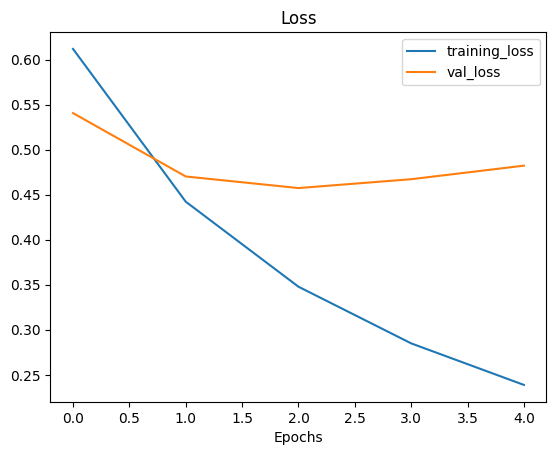

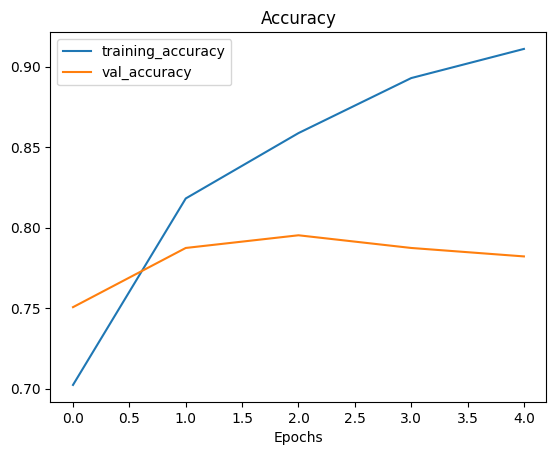

In [ ]:
plot_loss_curves(history=model_1_history)

## Visualizing learned embeddings

In [ ]:
# Get the vocubulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
words_in_vocab[:10], len(words_in_vocab)

(['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'], 10000)

In [ ]:
# Model_1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [ ]:
# Get the weight matrix in embedding layer
embed_weights = model_1.get_layer('embedding').get_weights()[0]
embed_weights

array([[-0.0344171 ,  0.00521355, -0.02661149, ..., -0.02156672,
        -0.03923165, -0.01885795],
       [-0.02301615, -0.01498932, -0.03957789, ...,  0.02440264,
        -0.00920519,  0.01643688],
       [-0.02067148, -0.01979128,  0.00581213, ..., -0.07085623,
        -0.04766713,  0.02293614],
       ...,
       [ 0.00303515,  0.0489598 ,  0.01795444, ...,  0.04784201,
        -0.02908242, -0.03843241],
       [ 0.00649151,  0.00540019,  0.02401559, ..., -0.01038293,
        -0.04564553,  0.02566832],
       [-0.04388503,  0.01952012,  0.05786462, ..., -0.07372756,
        -0.0222288 ,  0.04004823]], dtype=float32)

In [ ]:
embed_weights.shape

(10000, 128)

In [ ]:
# import io

# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(words_in_vocab):
#   if index == 0:
#     continue # skip
#   vec = embed_weights[index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\some_file")
#   out_m.write(word + "\some_file")
# out_v.close()
# out_m.close()

In [ ]:
# # Download from colab
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

## RNN - Recurrent Neural Network

RNN's are useful for sequence data.

The premise of a recurrent is to use the representation of a previous input to aid the representation of a later input

### Model 2: LSTM

LSTM - Long Short Term Memory

Our structure of an RNN typically looks like this:

```
Input(text) -> Tokenize -> Embedding -> Layers(RNNs/dense) -> Output(label probability)
```

In [ ]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(units=64, return_sequences=True)(x) # When you're stacking RNN cells together, you need to set return_sequence=True
x = layers.LSTM(units=64)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='Model_2')

In [ ]:
model_2.summary()

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                           

In [ ]:
# Compiling the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Fitting the model
history_2 = model_2.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences,val_labels),
                        callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                               experiment_name='Model_2_LSTM')])

Saving TensorBoard log files to: model_logs/Model_2_LSTM/20240610-125146
Epoch 1/5
215/215 [==============================] - 14s 41ms/step - loss: 0.2266 - accuracy: 0.9225 - val_loss: 0.5472 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1605 - accuracy: 0.9422 - val_loss: 0.6842 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1310 - accuracy: 0.9514 - val_loss: 0.6752 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1084 - accuracy: 0.9590 - val_loss: 0.6812 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0927 - accuracy: 0.9651 - val_loss: 0.7169 - val_accuracy: 0.7782


In [ ]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[1.6128210e-02],
       [8.5564601e-01],
       [9.9902689e-01],
       [7.7554457e-02],
       [6.1306159e-04],
       [9.7663862e-01],
       [8.4423411e-01],
       [9.9933112e-01],
       [9.9868244e-01],
       [3.5306802e-01]], dtype=float32)

In [ ]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 77.82152230971128,
 'precision': 0.7825342114649019,
 'recall': 0.7782152230971129,
 'f1': 0.7751716074860721}

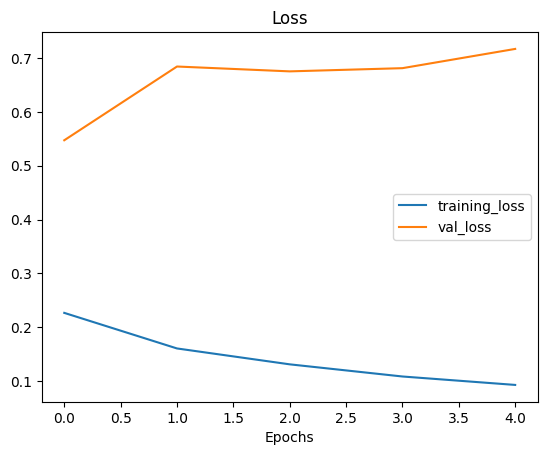

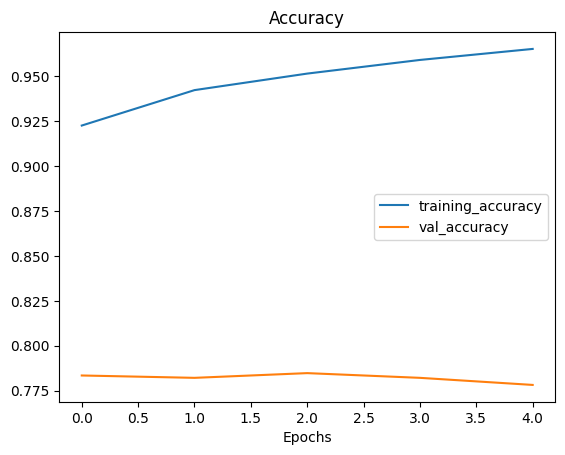

In [ ]:
plot_loss_curves(history_2)

### Model 3 - GRU

GRU - Gated Recurrent Unit

The basic idea behind GRU is to use gating mechanisms to selectively update the hidden state of the network at each time step. The gating mechanisms are used to control the flow of information in and out of the network.

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(units=64, return_sequences=True)(x)
x = layers.GRU(units=64)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_3 = tf.keras.Model(inputs, outputs, name='model_3_GRU')

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                       

In [ ]:
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
history_3 = model_3.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=create_tensorboard_callback(SAVE_DIR,
                                                              'Model_3_GRU'))

Saving TensorBoard log files to: model_logs/Model_3_GRU/20240610-125213
Epoch 1/5
215/215 [==============================] - 13s 38ms/step - loss: 0.1461 - accuracy: 0.9444 - val_loss: 0.6578 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0820 - accuracy: 0.9711 - val_loss: 0.8446 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0690 - accuracy: 0.9746 - val_loss: 0.8601 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0558 - accuracy: 0.9758 - val_loss: 1.5220 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0547 - accuracy: 0.9756 - val_loss: 1.6381 - val_accuracy: 0.7717


In [ ]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[1.5080882e-03],
       [5.4280508e-01],
       [9.9999428e-01],
       [2.1448743e-02],
       [2.2902179e-05],
       [9.9999475e-01],
       [9.9936908e-01],
       [9.9999797e-01],
       [9.9999678e-01],
       [3.8086224e-01]], dtype=float32)

In [ ]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 77.16535433070865,
 'precision': 0.7728196127186888,
 'recall': 0.7716535433070866,
 'f1': 0.7698331286570831}

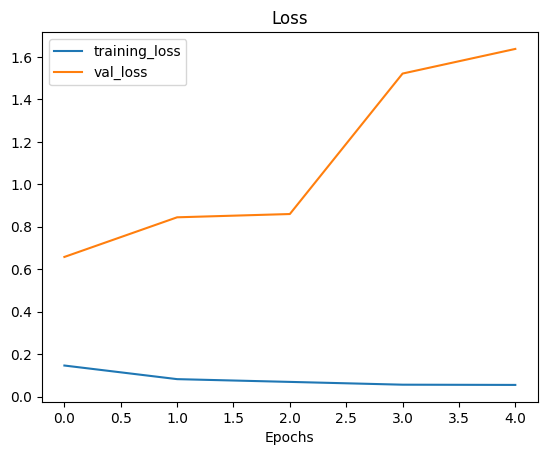

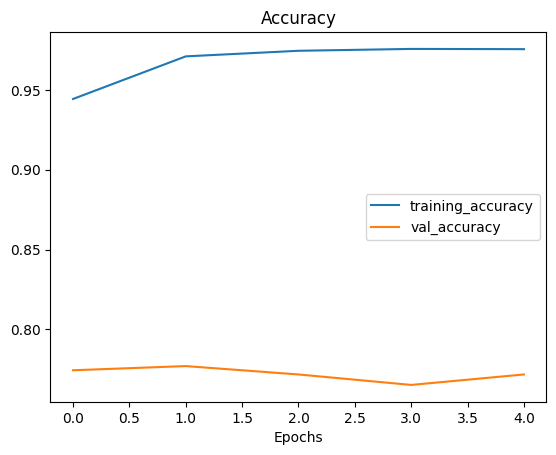

In [ ]:
plot_loss_curves(history_3)

#### Let's try to LSTM layer with GRU

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(units=64, return_sequences=True)(x)
x = layers.LSTM(units=64, return_sequences=True)(x)
x = layers.GRU(units=64)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_3_with_LSTM = tf.keras.Model(inputs, outputs, name='model_3_GRU_with_LSTM')

In [ ]:
model_3_with_LSTM.summary()

Model: "model_3_GRU_with_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru_2 (GRU)                 (None, 15, 64)            37248     
                                                                 
 lstm_2 (LSTM)               (None, 15, 64)            33024     
                                                                 
 gru_3 (GRU)                 (None, 64)                24960     
                                             

In [ ]:
model_3_with_LSTM.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
history_3_with_LSTM = model_3_with_LSTM.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences, val_labels),
                        callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                              'Model_3_GRU_with_LSTM')])

Saving TensorBoard log files to: model_logs/Model_3_GRU_with_LSTM/20240610-125239
Epoch 1/5
215/215 [==============================] - 17s 50ms/step - loss: 0.1167 - accuracy: 0.9631 - val_loss: 0.8832 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0620 - accuracy: 0.9758 - val_loss: 1.0322 - val_accuracy: 0.7598
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0485 - accuracy: 0.9771 - val_loss: 1.5231 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0515 - accuracy: 0.9768 - val_loss: 1.5132 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0447 - accuracy: 0.9796 - val_loss: 1.4639 - val_accuracy: 0.7756


In [ ]:
model_3_with_LSTM_pred_probs = model_3_with_LSTM.predict(val_sentences)
model_3_with_LSTM_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[8.8373003e-05],
       [6.5950197e-01],
       [9.9980694e-01],
       [1.7748842e-01],
       [1.5653875e-05],
       [9.9884844e-01],
       [9.7706848e-01],
       [9.9987566e-01],
       [9.9984145e-01],
       [2.6448801e-01]], dtype=float32)

In [ ]:
model_3_with_LSTM_preds = tf.squeeze(tf.round(model_3_with_LSTM_pred_probs))
model_3_with_LSTM_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_3_results_with_LSTM = calculate_results(val_labels, model_3_with_LSTM_preds)
model_3_results_with_LSTM

{'accuracy': 77.55905511811024,
 'precision': 0.7825199496133545,
 'recall': 0.7755905511811023,
 'f1': 0.7715339159155505}

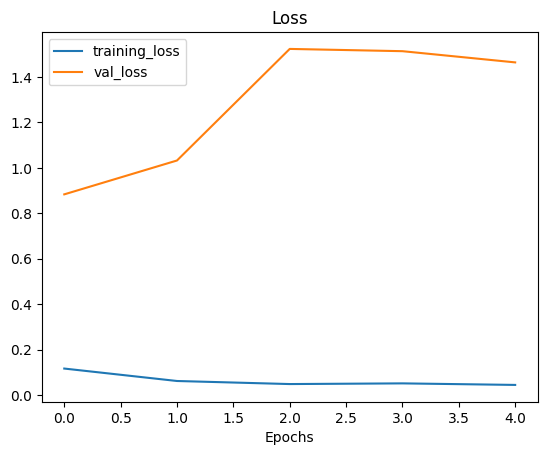

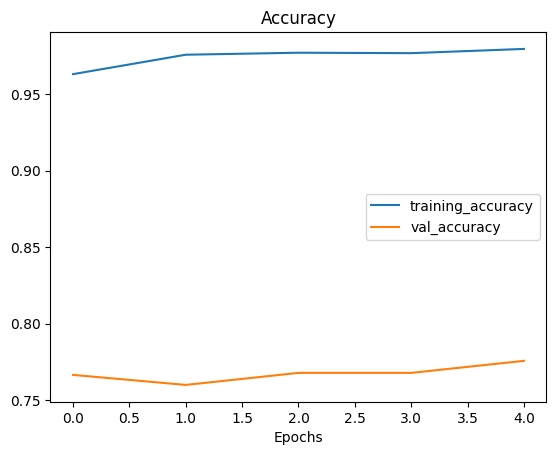

In [ ]:
plot_loss_curves(history_3_with_LSTM)

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

**Note** - Still couldn't beat the baseline model.

All the models (1, 2, 3) are overfitting.

### Model 4 - Bidirectional LSTM

Normal RNN's goes from left to right however bidirectional RNN's goes from left to right as well as right to left.

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(10, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(10))(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_4 = tf.keras.Model(inputs, outputs, name='model_4_Bidirectional')

In [ ]:
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 15, 20)            11120     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 20)                1920      
 onal)                                                           
                                             

In [ ]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['accuracy'])

In [ ]:
# Fit the model
history_4 = model_4.fit(train_sentences,
                        train_labels,
                        epochs=5,
                        validation_data=(val_sentences,val_labels),
                        callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                               'Model_4_bidirectional')])

Saving TensorBoard log files to: model_logs/Model_4_bidirectional/20240610-125311
Epoch 1/5
215/215 [==============================] - 17s 47ms/step - loss: 0.1604 - accuracy: 0.9689 - val_loss: 0.8399 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0560 - accuracy: 0.9774 - val_loss: 1.0683 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0407 - accuracy: 0.9804 - val_loss: 1.4506 - val_accuracy: 0.7546
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0360 - accuracy: 0.9825 - val_loss: 1.7532 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 2s 12ms/step - loss: 0.0350 - accuracy: 0.9825 - val_loss: 1.8721 - val_accuracy: 0.7323


In [ ]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 2s 6ms/step


array([[9.9420494e-01],
       [6.5735942e-01],
       [9.9997306e-01],
       [3.8561454e-01],
       [1.5867799e-05],
       [9.9998009e-01],
       [9.9902976e-01],
       [9.9999046e-01],
       [9.9998319e-01],
       [9.9756062e-01]], dtype=float32)

In [ ]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 73.22834645669292,
 'precision': 0.7346671616420156,
 'recall': 0.7322834645669292,
 'f1': 0.7327496376385787}

## CNN - Convolutional Neural Network for Text (and other types of sequences)

We've used CNN's for images but images are typically 2D ... however our text data is 1D.

Previously we've used Conv2D for our image data but this time we'll use Conv1D

The typically structure of a Conv1D model for sequences :

```
Inputs(texts) -> Tokenization -> Embedding -> Layers( Conv1D + pooling) -> Outputs
```

### Model 5 - Conv1D

In [ ]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[-0.07833132,  0.0104636 ,  0.04569174, ...,  0.05234856,
           0.02487041, -0.03217934],
         [-0.06994535,  0.02340454, -0.03537839, ..., -0.01810221,
          -0.02017388,  0.03477065],
         [-0.08153689,  0.01517993, -0.04772425, ...,  0.00638657,
          -0.00659847,  0.00931621],
         ...,
         [-0.03485307,  0.00336542,  0.00252042, ..., -0.02604698,
          -0.00191991, -0.00705171],
         [-0.03485307,  0.00336542,  0.00252042, ..., -0.02604698,
          -0.00191991, -0.00705171],
         [-0.03485307,  0.00336542,  0.00252042, ..., -0.02604698,
          -0.00191991, -0.00705171]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.02698317, 0.04905916, 0.        , 0.        , 0.07531305,
          0.        , 0.00271125, 0.        , 0.        , 0.        ,
          0.10284316, 0.        , 0.03178082, 0.        , 0.12712882,
          0.        , 0.

In [ ]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5,strides=1, activation="relu", padding='valid')(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [ ]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_9 (Dense)             (None, 64)             

In [ ]:
# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_5 =  model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240610-125400
Epoch 1/5
215/215 [==============================] - 9s 34ms/step - loss: 0.1190 - accuracy: 0.9602 - val_loss: 0.9367 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0605 - accuracy: 0.9745 - val_loss: 1.0449 - val_accuracy: 0.7572
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0422 - accuracy: 0.9816 - val_loss: 1.3733 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0355 - accuracy: 0.9820 - val_loss: 1.5091 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0326 - accuracy: 0.9832 - val_loss: 1.7586 - val_accuracy: 0.7612


In [ ]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[5.0519609e-01],
       [6.8888634e-01],
       [9.9999940e-01],
       [1.6089804e-01],
       [3.2251446e-09],
       [9.9994171e-01],
       [9.9367297e-01],
       [9.9999976e-01],
       [1.0000000e+00],
       [9.8025846e-01]], dtype=float32)

In [ ]:
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.11548556430446,
 'precision': 0.7615445184736523,
 'recall': 0.7611548556430446,
 'f1': 0.7596168376680188}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

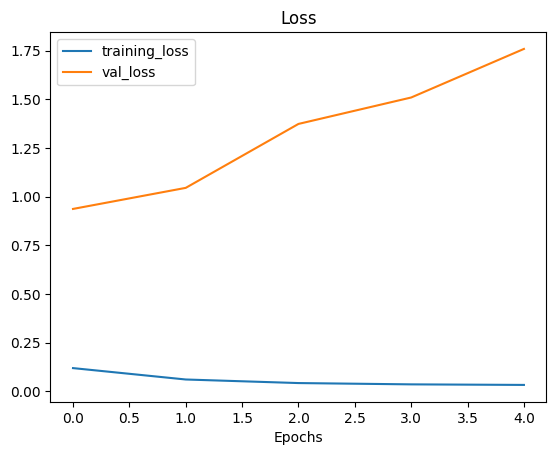

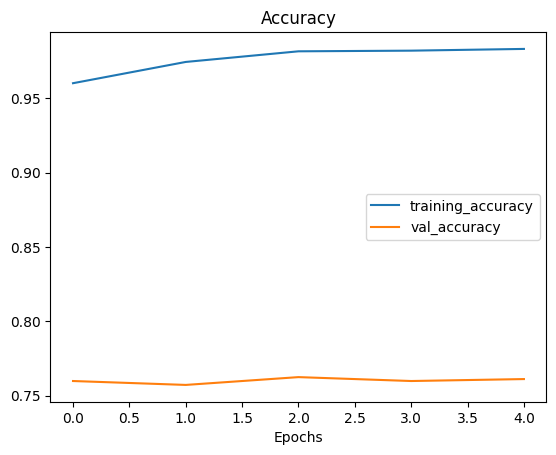

In [ ]:
plot_loss_curves(history_5)

## Model 6 - > Tensorflow Hub Pretrained Sentences Encoder

In [ ]:
sample_sentence = "There's a flood in my street!"

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2?tfhub-redirect=true")
embed_samples = embed([sample_sentence,
                       "When you call the universal sentence encoder on a sentence, it turns it into an embedding"])
print(embed_samples[0][:50])


tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [ ]:
embed_samples[0].shape

TensorShape([512])

In [ ]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2?tfhub-redirect=true",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

# Create model using Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name='model_6_USE')

In [ ]:
# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
history_6 = model_6.fit(train_sentences,
                  train_labels,
                  epochs=5,
                  validation_data=(val_sentences, val_labels),
                  callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                         'USE')])

Saving TensorBoard log files to: model_logs/USE/20240610-125451
Epoch 1/5
215/215 [==============================] - 6s 14ms/step - loss: 0.5086 - accuracy: 0.7813 - val_loss: 0.4483 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4151 - accuracy: 0.8173 - val_loss: 0.4388 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 2s 12ms/step - loss: 0.4027 - accuracy: 0.8215 - val_loss: 0.4334 - val_accuracy: 0.8071
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3940 - accuracy: 0.8266 - val_loss: 0.4348 - val_accuracy: 0.8058
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3870 - accuracy: 0.8283 - val_loss: 0.4292 - val_accuracy: 0.8110


In [ ]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 14ms/step


array([[0.19138692],
       [0.813527  ],
       [0.98969334],
       [0.22585945],
       [0.7607655 ],
       [0.74845433],
       [0.9834964 ],
       [0.98006207],
       [0.95174295],
       [0.13188422]], dtype=float32)

In [ ]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.10236220472441,
 'precision': 0.8113631917551808,
 'recall': 0.8110236220472441,
 'f1': 0.8102336058004983}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

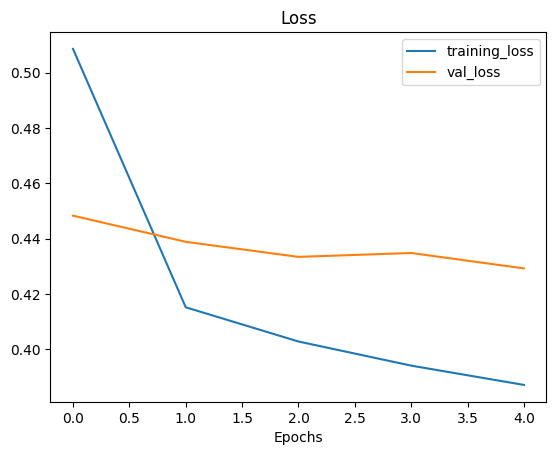

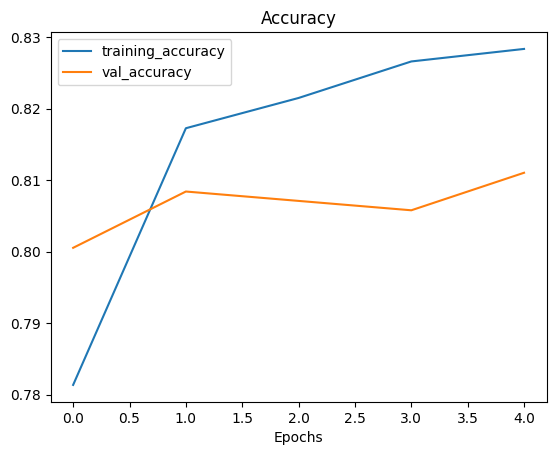

In [ ]:
plot_loss_curves(history_6)

**Note** - First model to beat baseline model and not overfitting the training sequence.

## Model 7 - TF Hub Pretrained USE with 10% training data

In [ ]:

# This data causes data leakage
# train_10_percent= train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
# train_10_percent

In [ ]:
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [ ]:
import numpy as np
import pandas as pd

pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
Name: count, dtype: int64

In [ ]:
# train_sentences_10_percent = train_10_percent['text'].to_list()
# train_labels_10_percent = train_10_percent['target'].to_list()

In [ ]:
# Checking the split of target
# train_10_percent['target'].value_counts()

target
0    413
1    348
Name: count, dtype: int64

In [ ]:
# Let's build the model
model_7 = tf.keras.models.clone_model(model_6)

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_11 (Dense)            (None, 64)                32832     
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
history_7 = model_7.fit(train_sentences_10_percent,
            train_labels_10_percent,
            epochs=5,
            validation_data=(val_sentences, val_labels),
                  callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                         'model_7_10_percent_USE_data_leakage_solved')])

Saving TensorBoard log files to: model_logs/model_7_10_percent_USE_data_leakage_solved/20240610-132905
Epoch 1/5
22/22 [==============================] - 5s 47ms/step - loss: 0.6734 - accuracy: 0.6715 - val_loss: 0.6498 - val_accuracy: 0.7362
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.6033 - accuracy: 0.8073 - val_loss: 0.5906 - val_accuracy: 0.7664
Epoch 3/5
22/22 [==============================] - 0s 20ms/step - loss: 0.5275 - accuracy: 0.8219 - val_loss: 0.5361 - val_accuracy: 0.7651
Epoch 4/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4660 - accuracy: 0.8248 - val_loss: 0.5048 - val_accuracy: 0.7717
Epoch 5/5
22/22 [==============================] - 0s 21ms/step - loss: 0.4237 - accuracy: 0.8321 - val_loss: 0.4871 - val_accuracy: 0.7730


In [ ]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[0.22878677],
       [0.600377  ],
       [0.93533957],
       [0.35812938],
       [0.5443632 ],
       [0.734273  ],
       [0.8996152 ],
       [0.81707555],
       [0.874016  ],
       [0.17062949]], dtype=float32)

In [ ]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.29658792650919,
 'precision': 0.7726091269398356,
 'recall': 0.7729658792650919,
 'f1': 0.772485380005067}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

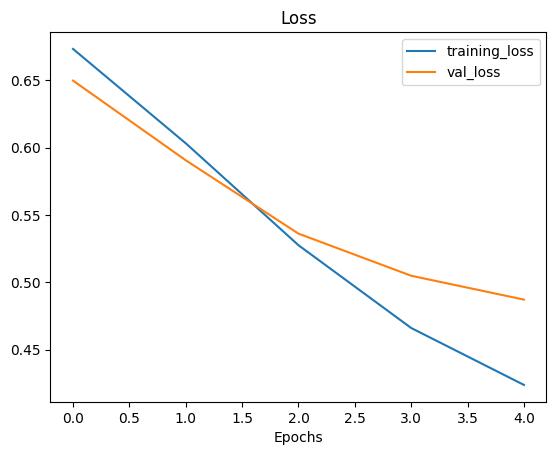

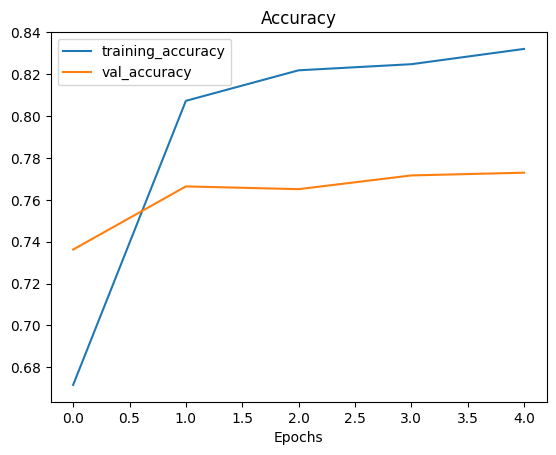

In [ ]:
plot_loss_curves(history_7)

**Note** - The reason for higher accuracy was because of data leakage. We are taking train_10_percent and val_sentences from train_shuffled so the model has already know some of the validation data.

## Comparing the performance of each of our models

In [ ]:
results = pd.DataFrame({"0_baseline": baseline_results,
                        "1_simple_dense": model_1_results,
                        "2_LSTM": model_2_results,
                        "3_GRU": model_3_results,
                        "4_bidirectional": model_4_results,
                        "5_conv1d": model_5_results,
                        "6_tf_hub_use_encoder": model_6_results,
                        "7_tf_hub_use_encode_10_percent": model_7_results})

results = results.transpose()
results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.215223,0.786040,0.782152,0.779381
2_LSTM,77.821522,0.782534,0.778215,0.775172
3_GRU,77.165354,0.772820,0.771654,0.769833
4_bidirectional,73.228346,0.734667,0.732283,0.732750
5_conv1d,76.115486,0.761545,0.761155,0.759617
6_tf_hub_use_encoder,81.102362,0.811363,0.811024,0.810234
7_tf_hub_use_encode_10_percent,77.296588,0.772609,0.772966,0.772485


In [ ]:
# Reduce the accuracy to the same scale as other metrics
results['accuracy'] = results['accuracy']/100

In [ ]:
results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.782152,0.786040,0.782152,0.779381
2_LSTM,0.778215,0.782534,0.778215,0.775172
3_GRU,0.771654,0.772820,0.771654,0.769833
4_bidirectional,0.732283,0.734667,0.732283,0.732750
5_conv1d,0.761155,0.761545,0.761155,0.759617
6_tf_hub_use_encoder,0.811024,0.811363,0.811024,0.810234
7_tf_hub_use_encode_10_percent,0.772966,0.772609,0.772966,0.772485


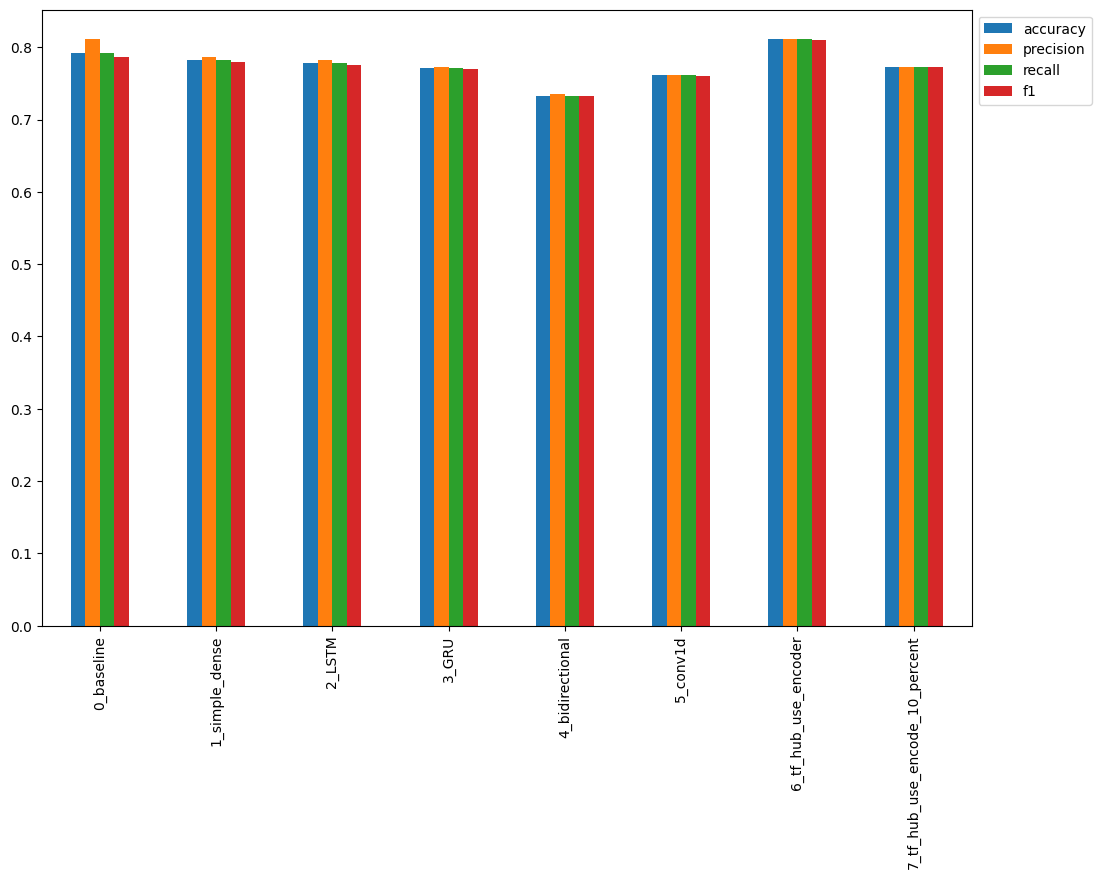

In [ ]:
results.plot(kind='bar', figsize=(12, 8)).legend(bbox_to_anchor=(1.0, 1.0));

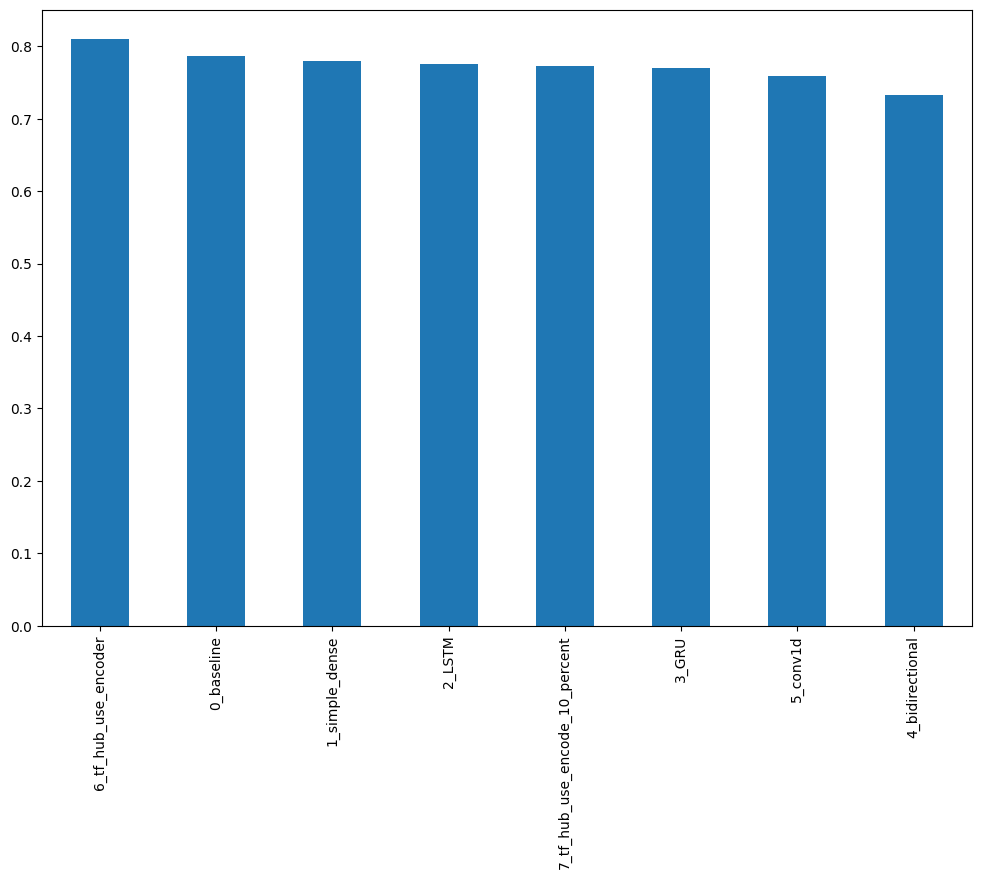

In [ ]:
results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(12, 8));

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* Out of these wrong examples which ones is it getting *most* wrong


In [ ]:
# Download a pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip

unzip_data(filename='08_model_6_USE_feature_extractor.zip')

--2024-06-10 13:54:23--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.207, 173.194.215.207, 173.194.216.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip.1’

08_model_6_USE_feat 100%[===================>] 916.27M   153MB/s    in 9.0s    

2024-06-10 13:54:32 (102 MB/s) - ‘08_model_6_USE_feature_extractor.zip.1’ saved [960779165/960779165]



In [ ]:
model_6_pretrained = tf.keras.models.load_model(filepath='08_model_6_USE_feature_extractor')

In [ ]:
model_6_pretrained.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_11 (Dense)            (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [ ]:
# Make predictions
model_6_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.1597574 ],
       [0.747162  ],
       [0.98874855],
       [0.19622944],
       [0.7078079 ],
       [0.7096747 ],
       [0.98190695],
       [0.9810662 ],
       [0.94574374],
       [0.08504029]], dtype=float32)

In [ ]:
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Create DataFrame with validation sentences and best performing model predictions
val_df = pd.DataFrame({'text': val_sentences,
                       'target': val_labels,
                       'pred': model_6_preds,
                       'pred_prob': tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [ ]:
most_wrong = val_df[val_df['target'] != val_df['pred']].sort_values("pred_prob",ascending=False)

In [ ]:
most_wrong.head()

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213


In [ ]:
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")


Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769820928573608
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272132277488708
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [ ]:
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.05507583171129227
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.05460337549448013
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.054597001522779465
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.049637261778116226
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.04391850158572197
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0.

In [ ]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

1/1 [==============================] - 0s 92ms/step
Pred: 1, Prob: 0.6046446561813354
Text:
Bioterrorism and Ebola. http://t.co/ORIOVftLK4 RT #STOPIslam #TCOT #CCOT #MakeDCListen #TeaParty

-----

1/1 [==============================] - 0s 116ms/step
Pred: 1, Prob: 0.970478892326355
Text:
#Aphid population in #NorthIowa has exploded in last 4 days! http://t.co/cw6jxYVbNj #FromTheField

-----

1/1 [==============================] - 0s 67ms/step
Pred: 1, Prob: 0.9911376237869263
Text:
Hopefully this will bring some closure for the families #MH370: Malaysian PM confirms debris is from missing flight http://t.co/2963y36LdF

-----

1/1 [==============================] - 0s 63ms/step
Pred: 0, Prob: 0.16460944712162018
Text:
@R_o_M by a landslide.

-----

1/1 [==============================] - 0s 68ms/step
Pred: 0, Prob: 0.18977293372154236
Text:
13 reasons why we love women in the military   - lulgzimbestpicts http://t.co/tRgPWOuj6X http://t.co/GEMNUZoCeb

-----

1/1 [========================

## The speed/score tradeoff

In [ ]:
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time-start_time
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [ ]:
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 11ms/step


(0.38112075600020034, 0.0005001584724412078)

In [ ]:
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.07208426899978804, 9.459877821494494e-05)

In [ ]:
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

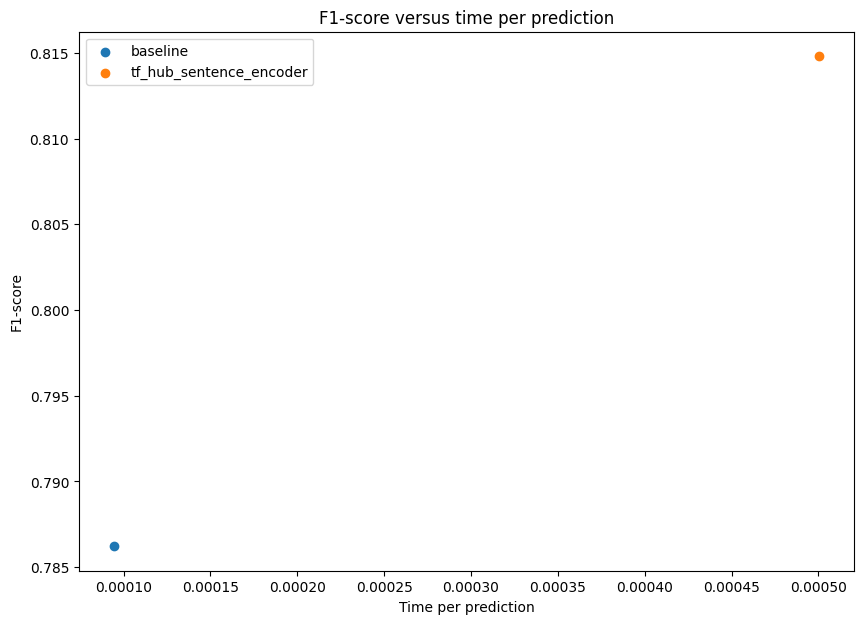

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");